## Instructions

To decrease frustration when something unexpected happens, save a model checkpoint after each training epoch. If you're running on Colab, save them to your Google drive. Make a helper routine that restarts training from a saved model with a given epoch counter.


1. Choose a dataset (TF datasets or some of your own choice, NOT Keras
datasets).
2. Choose a CNN model. Use a pretrained model from TF Hub or Keras applications (or some other, should you find one). I'd recommend EfficientNet (B0 or B1), but feel free to choose. https://keras.io/api/applications/efficientnet/
3. Implement preprocessing. Your model may work only on images of a certain size, so crop and rescale if needed. Be sure to use the preprocessing operation that comes with the model package - some map pixels to [0,1] and some to [-1,1].
4. Build an input pipeline. Preprocessing should be a part of it. Minibatches should fit into GPU memory.
5. Load only the convolutional base of the pre-trained model and build your own decision part on top of that (e.g. two dense layers + softmax). Sometimes a global averaging of the base model output is needed (some architectures do it as their last step, some don't).
6. Implement data augmentation. Use the augmentation layers (build own custom ones if you like) and add them between the input layer and the pre-trained model (use the functional API)
7. Establish a baseline: train and validate your model (with an optimizer of your choice). Plot loss and accuracy curves.
8. Fine-tune the model (trained at 7) by opening a few layers (or layer blocks if it's more natural in the model architecture) at a time. Train with a very small learning rate (might take a few tries to find a good starting value). Repeat opening layers until there's no improvement. 
9. Redo steps 7 and 8 with the following additions to the decision part you built:
        L2 regularization
        Batch Normalization
        Dropout (with small rate) just before softmax
        learning rate scheduler callback


## Import libraries

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import os
import math
from google.colab import drive

from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.preprocessing import image

import tensorflow as tf
import tensorflow_datasets as tfds

## Load the data
In this excercise, I'm using the Tensorflow Oxford Flowers 102 data set.

In [ ]:

batch_size = 32
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    'oxford_flowers102',
    split=['test', 'train', 'validation'], # the test set is huge compared to the others, so use it as a train set
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
ds_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [ ]:
tf.data.experimental.cardinality(ds_train)

<tf.Tensor: shape=(), dtype=int64, numpy=6149>

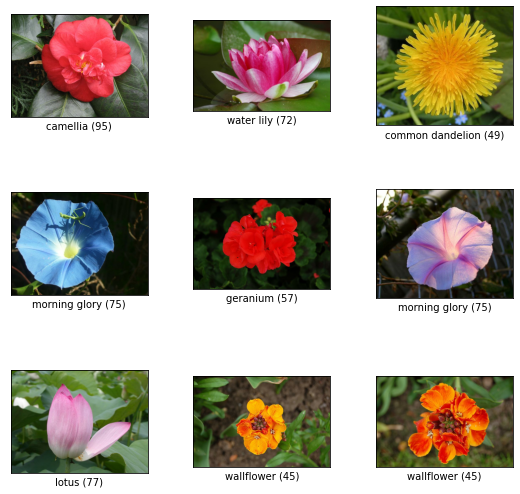

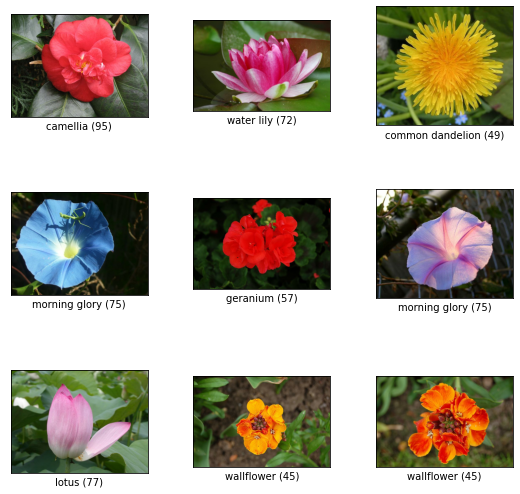

In [ ]:
# let's have a look at the data
tfds.show_examples(ds_train, ds_info)


In [ ]:
num_classes = ds_info.features['label'].num_classes
print("Number of classes:",num_classes)

print("Labels:",ds_info.features['label'].names)
print("Image shape:",ds_info.features['image'].shape)


Number of classes: 102
Labels: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahl

In [ ]:
IMG_SIZE = 128 # 224 is the size the efficientnet takes as input -> try a smaller size to fit more examples into RAM

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.repeat(5) # ran out of memory while training with repeat of 10, thus smaller value
# rezise and and pad to squares
ds_train = ds_train.map(lambda image, label: (tf.image.pad_to_bounding_box(tf.image.resize(image, size, preserve_aspect_ratio=True), 0,0,IMG_SIZE,IMG_SIZE), label))
ds_val = ds_val.map(lambda image, label: (tf.image.pad_to_bounding_box(tf.image.resize(image, size, preserve_aspect_ratio=True), 0,0,IMG_SIZE,IMG_SIZE), label))
ds_test = ds_test.map(lambda image, label: (tf.image.pad_to_bounding_box(tf.image.resize(image, size, preserve_aspect_ratio=True), 0,0,IMG_SIZE,IMG_SIZE), label))

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

train = configure_for_performance(ds_train)
val = configure_for_performance(ds_val)
test = configure_for_performance(ds_test)


## Load the pretrained model

In [ ]:
pretrained_model = EfficientNetB1(
    weights="imagenet",
    include_top=False,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

pretrained_model.summary()
print("Number of layers in the base model: ", len(pretrained_model.layers))

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

## Functions and prep
Run these in beginning of each session in order to train models

In [ ]:
# a builder function to make my life easier
def build_baseline_model():
  inputs = tf.keras.Input(shape=(None, None, 3))
  x = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
      ])(inputs) # data augmentation
  x = pretrained_model(x)
  pooling = tf.keras.layers.GlobalAveragePooling2D()(x) 
  x = tf.keras.layers.Dense(256)(pooling)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), # use sparse categorical crossentropy as loss
                metrics=['accuracy'])
  return model

In [ ]:
# mount google drive
drive.mount('/content/gdrive')
directory = "/content/gdrive/My Drive/checkpoints/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir '{directory}' #directory for saving the checkpoints

mkdir: cannot create directory ‘/content/gdrive/My Drive/checkpoints/’: File exists


In [ ]:
# create a callback for checkpoints
# and a method for creating one with a new save file location

callbacks = []

def make_checkpoint_callback(file_path, best=False):
  if not best:
    checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                            monitor='val_loss', 
                            verbose=1, 
                            save_best_only=False,
                            save_weights_only=True,
                            save_freq='epoch',
                            mode='min')
  else:
    checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                          monitor='val_loss', 
                          verbose=1, 
                          save_best_only=True,
                          save_weights_only=True,
                          save_freq='epoch',
                          mode='min')
  return checkpointCallback

earlystopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, mode='min')


In [ ]:
# learning curve function for accuracy and loss

def learning_curves(history):
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # learning curve for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
# open 3 layers at a time from a base model and train until we reach an block where the model isn't learning

def finetune(model, callbacks:list, lr):
    min_loss = math.inf
    block_min = math.inf
    histdict = {'accuracy':[], 'val_accuracy':[], 'loss':[], 'val_loss':[]} 
    # history as is returns only the last training block, so track it manually
    i = 3
    trainepochs = 1
    learning = True
    wait = 0
    while learning:
      pretrained_model.trainable = True
      for layer in pretrained_model.layers[:-i]:
        layer.trainable =  False

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

      history = model.fit(train,
                        epochs=trainepochs,
                        initial_epoch=trainepochs-1,
                        validation_data=val,
                        callbacks=callbacks)

      if history.history['val_loss'][-1] < block_min:
        block_min = history.history['val_loss'][-1]
      else:
        print("learning stopped for this block, opening new layers")
        i += 3 # open a few more layers if a layer block has stopped learning
        block_min = math.inf # set a bigger number for the next block minimum
      if history.history['val_loss'][-1] < min_loss:
        min_loss = history.history['val_loss'][-1]
        wait = 0 # if a new minimum was reached, reset patience
      else:
        print("val_loss did not improve from", min_loss)
        wait += 1 # this sort of acts as a patience, but not the most fancy method
      if wait >= 5:
        learning = False
      trainepochs += 1
      histdict['loss'].extend(history.history['loss'])
      histdict['val_loss'].extend(history.history['val_loss'])
      histdict['accuracy'].extend(history.history['accuracy'])
      histdict['val_accuracy'].extend(history.history['val_accuracy'])
    return histdict

      
      


## Baseline model

In [ ]:
# build the model
pretrained_model.trainable = False
bl_model = build_baseline_model()
bl_model.summary()
checkpointCallback = make_checkpoint_callback(directory+"bl-{epoch:03d}.hdf5")
bestmodelcallback = make_checkpoint_callback(directory+"bl-best.hdf5", best=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 102)               26214     
                                                           

In [ ]:
# fit the model
bl_history = bl_model.fit(train,
                    epochs=50,
                    validation_data=val,
                    callbacks=[checkpointCallback, earlystopping, bestmodelcallback])


Epoch 1/50
960/960 [==============================] - ETA: 0s - loss: 3.2409 - accuracy: 0.3131
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoints/bl-001.hdf5

Epoch 00001: val_loss improved from inf to 2.79674, saving model to /content/gdrive/My Drive/checkpoints/bl-best.hdf5
960/960 [==============================] - 109s 100ms/step - loss: 3.2409 - accuracy: 0.3131 - val_loss: 2.7967 - val_accuracy: 0.3569
Epoch 2/50
960/960 [==============================] - ETA: 0s - loss: 1.9147 - accuracy: 0.5830
Epoch 00002: saving model to /content/gdrive/My Drive/checkpoints/bl-002.hdf5

Epoch 00002: val_loss improved from 2.79674 to 1.87297, saving model to /content/gdrive/My Drive/checkpoints/bl-best.hdf5
960/960 [==============================] - 75s 78ms/step - loss: 1.9147 - accuracy: 0.5830 - val_loss: 1.8730 - val_accuracy: 0.5575
Epoch 3/50
960/960 [==============================] - ETA: 0s - loss: 1.3770 - accuracy: 0.6930
Epoch 00003: saving model to /content/gdrive/M

Test set evaluation:
31/31 [==============================] - 5s 70ms/step - loss: 0.6384 - accuracy: 0.8155
Loss: 0.6384198069572449 acc: 0.8155242204666138


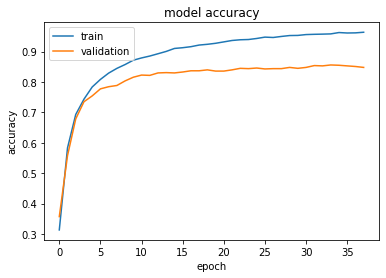

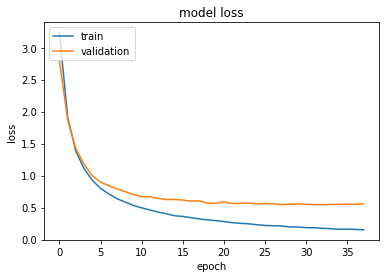

In [ ]:
# test set evaluation with the best weights:
print("Test set evaluation:")
bl_model.load_weights(directory+'bl-best.hdf5')
baseline_eval = bl_model.evaluate(test)
print("Loss:", baseline_eval[0], "acc:", baseline_eval[1])

learning_curves(bl_history.history)

The baseline model trained for 38 epochs. During the initial training, the model reached test accuracy of 0.82 and test loss of 0.64. The validation set reached 0.85 accuracy and 0.56 loss before overfitting.

## Fine tuning

In [ ]:
pretrained_model.trainable = False # this in case I have to reset the training 
bl_finetune_model = build_baseline_model()
#load the weights from the baseline model's best epoch
bl_finetune_model.load_weights(directory+'bl-best.hdf5')

checkpointCallback = make_checkpoint_callback(directory+"bl-finetune-{epoch:03d}.hdf5")
bl_finetune = finetune(bl_finetune_model, [checkpointCallback, earlystopping], 1e-5) # smaller learning rate than before

960/960 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8933
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoints/bl-finetune-001.hdf5
960/960 [==============================] - 111s 100ms/step - loss: 0.3705 - accuracy: 0.8933 - val_loss: 0.6768 - val_accuracy: 0.8337
Epoch 2/2
960/960 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.9235
Epoch 00002: saving model to /content/gdrive/My Drive/checkpoints/bl-finetune-002.hdf5
960/960 [==============================] - 87s 80ms/step - loss: 0.2622 - accuracy: 0.9235 - val_loss: 0.6250 - val_accuracy: 0.8518
Epoch 3/3
960/960 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9362
Epoch 00003: saving model to /content/gdrive/My Drive/checkpoints/bl-finetune-003.hdf5
960/960 [==============================] - 87s 80ms/step - loss: 0.2220 - accuracy: 0.9362 - val_loss: 0.6194 - val_accuracy: 0.8518
Epoch 4/4
960/960 [==============================] - ETA: 0s - 

In [ ]:
bl_finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 102)               26214     
                                                             

Test set evaluation:
31/31 [==============================] - 4s 69ms/step - loss: 0.6169 - accuracy: 0.8397
Loss: 0.6168848872184753 acc: 0.8397177457809448


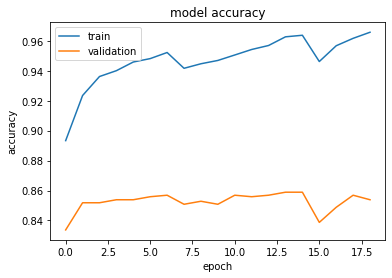

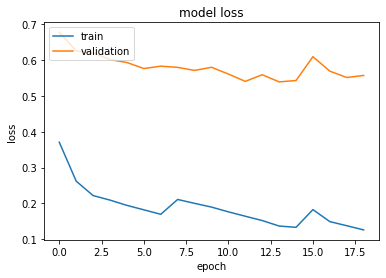

In [ ]:
print("Test set evaluation:")
bl_finetune_eval = bl_finetune_model.evaluate(test)
print("Loss:", bl_finetune_eval[0], "acc:", bl_finetune_eval[1])

learning_curves(bl_finetune)

The fine-tuning ran for additional 19 epochs and ended up opening 15 layers from the pretrained model, total number of trainable parameters is thus 1,711,670.

The model reached 0.86 validation accuracy and 0.54 validation loss before stopping. The model has a test accuracy of 0.84 and a test loss of 0.62 respectively.

The improvement isn't huge compared to the baseline model (test loss 0.64, test acc 0.82)

## Further improvements
```
 L2 regularization
 Batch Normalization
 Dropout (with small rate) just before softmax
 learning rate scheduler callback
```




In [ ]:
def build_improved_model():
  inputs = tf.keras.Input(shape=(None, None, 3))
  x = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
      ])(inputs)
  x = pretrained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x) 
  x = tf.keras.layers.Dense(256, kernel_regularizer='l2')(x) # L2 reguralizer layer
  x = tf.keras.layers.BatchNormalization()(x) # batch normalization layer
  x = tf.keras.layers.Dropout(0.1)(x) # drop out layer with 10 % dropout
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  improved_model = tf.keras.Model(inputs, outputs)

  improved_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return improved_model

pretrained_model.trainable = False
improved_model = build_improved_model()
improved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                               

In [ ]:
# this is following the example from https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
# this halves the learning rate every 10 epochs
# modify the learning rate accordingly for the fine tune section
def step_decay(epoch):
   initial_lrate = 5e-5
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
checkpointCallback = make_checkpoint_callback(directory+"improved-{epoch:03d}.hdf5")
bestmodelcallback = make_checkpoint_callback(directory+"improved-best.hdf5", best=True)

improved_history = improved_model.fit(train,
                    epochs=50,
                    validation_data=val,
                    callbacks=[checkpointCallback, earlystopping, lrate, bestmodelcallback])

Epoch 1/50
960/960 [==============================] - ETA: 0s - loss: 6.7024 - accuracy: 0.3507
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoints/improved-001.hdf5

Epoch 00001: val_loss improved from inf to 5.38329, saving model to /content/gdrive/My Drive/checkpoints/improved-best.hdf5
960/960 [==============================] - 89s 82ms/step - loss: 6.7024 - accuracy: 0.3507 - val_loss: 5.3833 - val_accuracy: 0.4798 - lr: 5.0000e-05
Epoch 2/50
960/960 [==============================] - ETA: 0s - loss: 4.3401 - accuracy: 0.6438
Epoch 00002: saving model to /content/gdrive/My Drive/checkpoints/improved-002.hdf5

Epoch 00002: val_loss improved from 5.38329 to 3.80696, saving model to /content/gdrive/My Drive/checkpoints/improved-best.hdf5
960/960 [==============================] - 75s 78ms/step - loss: 4.3401 - accuracy: 0.6438 - val_loss: 3.8070 - val_accuracy: 0.6694 - lr: 5.0000e-05
Epoch 3/50
960/960 [==============================] - ETA: 0s - loss: 3.1842 - accurac

Test set evaluation:
31/31 [==============================] - 2s 71ms/step - loss: 0.8426 - accuracy: 0.8296
Loss: 0.8426461219787598 acc: 0.8296371102333069


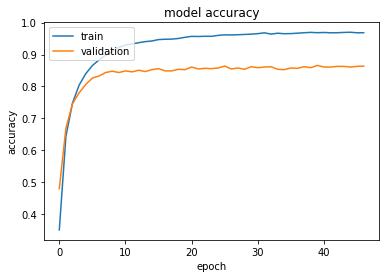

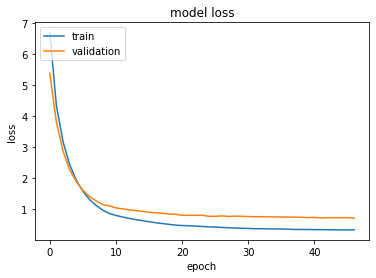

In [ ]:
print("Test set evaluation:")
improved_model.load_weights(directory+'improved-best.hdf5')
improved_eval = improved_model.evaluate(test)
print("Loss:", improved_eval[0], "acc:", improved_eval[1])

learning_curves(improved_history.history)

The initial training ran for 47 epochs. During the training, the improved model reached test accuracy of 0.83 and test loss of 0.84. The loss here is quite high, accuracy is slightly better than in the baseline model after the initial training.

In [ ]:
#lr = step_decay(index(min(improved_history.history['val_loss'])))
lr = step_decay(42) # set the epoch by hand if GPU session expired
# find the epoch where the best weights were saved and calculate appropriate learning rate

def finetune_step_decay(epoch):
   initial_lrate = lr
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(finetune_step_decay)

In [ ]:
pretrained_model.trainable = False
improved_finetune_model = build_improved_model()
#load the weights from the previous model's best epoch
improved_finetune_model.load_weights(directory+"improved-best.hdf5")

checkpointCallback = make_checkpoint_callback(directory+"improved-finetune-{epoch:03d}.hdf5")
improved_finetune = finetune(improved_finetune_model, [checkpointCallback, lrate], lr) 

960/960 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.9145
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoints/improved-finetune-001.hdf5
960/960 [==============================] - 118s 101ms/step - loss: 0.5454 - accuracy: 0.9145 - val_loss: 0.9274 - val_accuracy: 0.8266 - lr: 3.1250e-06
Epoch 2/2
960/960 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.9362
Epoch 00002: saving model to /content/gdrive/My Drive/checkpoints/improved-finetune-002.hdf5
960/960 [==============================] - 87s 80ms/step - loss: 0.4627 - accuracy: 0.9362 - val_loss: 0.8572 - val_accuracy: 0.8387 - lr: 3.1250e-06
Epoch 3/3
960/960 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.9428
Epoch 00003: saving model to /content/gdrive/My Drive/checkpoints/improved-finetune-003.hdf5
960/960 [==============================] - 88s 81ms/step - loss: 0.4300 - accuracy: 0.9428 - val_loss: 0.8353 - val_accuracy: 0.8397 - lr: 3.125

In [ ]:
improved_finetune_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                           

Test set evaluation:
31/31 [==============================] - 4s 71ms/step - loss: 0.9477 - accuracy: 0.8054
Loss: 0.9477037787437439 acc: 0.805443525314331


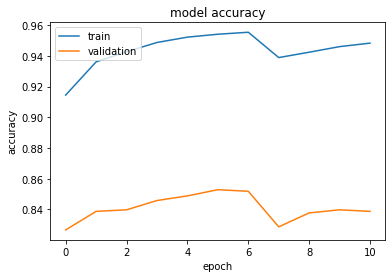

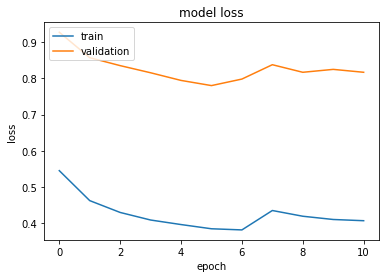

In [ ]:
print("Test set evaluation:")
improved_finetune_eval = improved_finetune_model.evaluate(test)
print("Loss:", improved_finetune_eval[0], "acc:", improved_finetune_eval[1])

learning_curves(improved_finetune)

The finetuning ran for additional 11 epochs and ended up opening 6 layers from the pretrained model, total number of trainable parameters is thus 1,537,382.

The model reached 0.85 validation accuracy and 0.78 validation loss at best before stopping. The model has a test accuracy of 0.81 and a test loss of 0.94 respectively. Compared to the previous fine-tuned model, this performed worse. The test set evalution results are also worse than the initial baseline model. Maybe a different patience number could have been experimented with to see if the model would've improved from this.

## Discussion

The learning rates I chose (5e-5 and 1e-5) were based on a couple of experiments, but a more "objective" and efficient method could have been trying to automatize the learning rate choosing process. The fine-tuning method here isn't the cleanest possible. It could have been made into a callback, for instance.

I decided to add the further improvements to one single model, but they could have been added separately to better inspect the effect one single change has on the model. Now, even though we can see that the model performed a little bit better with the improvements than without, it is not clear which of them had the greatest impact.

Further augmentation of the data could've resulted in a better model, but the data amount was limited by Colab's resource restrictions.
